---

In [3]:
# 통계
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels

#  기본
import  numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings(action='ignore')

# 시각화
from dataprep.eda import plot, plot_correlation, plot_missing
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib
import graphviz

# 전처리
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# 표본추출
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, RepeatedKFold

# 하이퍼파라미터 튜닝
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

# model
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance, plot_tree
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree


# pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# 평가지표
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# 크롤링
import requests
from bs4 import BeautifulSoup
import json

# 데이터셋
from sklearn.datasets import make_regression, make_classification, make_blobs

# 한글 폰트, 선명도
%config inlinebackend.figure_format = "retina"
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')        

try : 
    if platform.system() == 'Windows':
    # 윈도우인 경우
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    else:    
    # Mac 인 경우
        rc('font', family='AppleGothic')
except : 
    pass
matplotlib.rcParams['axes.unicode_minus'] = False 


In [644]:
# pandas, numpy, matplotlib.pyplot, seaborn, os 등 필요 라이브러리 호출

data = pd.read_csv("C:/Users/User/박은호/KT AIVLE SCHOOL/실습자료_DX 미프3차 1일차(3.15)/data/train_data.csv")
data.drop(columns = ["subject"], inplace = True)

# RandomForest's feature importances

In [618]:
X = data.drop("Activity", axis = 1)
y = data[["Activity"]]

In [621]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 2023, stratify = y)

rf = RandomForestClassifier(random_state = 2023)
rf.fit(X_train, y_train)
print("Train Score : ", rf.score(X_train, y_train))

Train Score :  1.0


In [625]:
importances = pd.DataFrame()
importances["feature_name"] = X_train.columns
importances["importance"] = rf.feature_importances_

importances = importances.sort_values(by = "importance", ascending = False)
importances.reset_index(drop = True, inplace = True)

In [647]:
top20 = list(importances.head(20).feature_name.values)

In [649]:
X_top20 = data[top20]
y_top20 = data[["Activity"]]

X20_train, X20_test, y20_train, y20_test = train_test_split(X_top20, y_top20, test_size = 0.3,
                                                            random_state = 2023, stratify = y_top20)

- 기본 모델들

In [650]:
# 기본 모델들

models = [KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression()]

param_grids = [{"n_neighbors" : np.arange(1,11)},
               {"max_depth" : np.arange(1,11)},
               {"C" : np.logspace(-3,3,7)}]


top20_scores = pd.DataFrame()

for model, param_grid in zip(models, param_grids):
    top20 = GridSearchCV(model, param_grid = param_grid, cv = 3)
    top20.fit(X20_train, y20_train)
    top20_scores[f"{model}"] = [top20.best_score_, top20.best_params_]
    
top20_scores.index = ["Best score", "Best params"]

In [652]:
top20_scores.T.reset_index(drop = False)
top20_scores_T = top20_scores.T.reset_index(drop = False)
top20_scores_T= top20_scores_T.rename(columns = {"index":"model"})
top20_scores_T.model = top20_scores_T.model.str.slice(start = 0, stop = -2 )

In [656]:
top20_scores_T

,model,Best score,Best params
0,KNeighborsClassifier,0.949466,{'n_neighbors': 1}
1,DecisionTreeClassifier,0.932459,{'max_depth': 10}
2,LogisticRegression,0.913994,{'C': 100.0}


 - xgboost

In [654]:
# xgboost

mapping = {'STANDING':0, 'SITTING':1, 'LAYING':2, 'WALKING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5}
y20_map_train = y20_train.replace(mapping)
y20_map_val = y20_test.replace(mapping)

param_grid = {'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [2,3,4]}

top20_xg = GridSearchCV(XGBClassifier(random_state = 2023),
                           param_grid, cv = 3, return_train_score = True, verbose=2)

top20_xg.fit(X20_train, y20_map_train)

print(f"Best Score : {top20_xg.best_score_:.2f}")
print("Best params : ", top20_xg.best_params_)
# print(f"Test Set Score : {grid_search.score(X_pca_val, y_map_val)}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....................learning_rate=0.01, max_depth=2; total time=   2.2s
[CV] END ....................learning_rate=0.01, max_depth=2; total time=   2.2s
[CV] END ....................learning_rate=0.01, max_depth=2; total time=   2.3s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   2.6s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   2.7s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   2.4s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=   3.0s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=   3.0s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=   3.3s
[CV] END .....................learning_rate=0.1, max_depth=2; total time=   2.6s
[CV] END .....................learning_rate=0.1, max_depth=2; total time=   2.6s
[CV] END .....................learning_rate=0.1, 

In [657]:
top20_scores_T.loc[3,:] = ["XGBoostClassifier", top20_xg.best_score_, top20_xg.best_params_]
top20_scores_T

,model,Best score,Best params
0,KNeighborsClassifier,0.949466,{'n_neighbors': 1}
1,DecisionTreeClassifier,0.932459,{'max_depth': 10}
2,LogisticRegression,0.913994,{'C': 100.0}
3,XGBoostClassifier,0.965743,"{'learning_rate': 0.3, 'max_depth': 4}"


 - randomforest

In [658]:
param_grid = {"max_depth" : [10,15,None],
              "n_estimators" : [500, 700, 900],
               "max_features" : [2, 4, 6]}

rf_20 = GridSearchCV(RandomForestClassifier(random_state = 2023), param_grid = param_grid,
                     scoring = "accuracy", cv = 5, return_train_score = True, n_jobs = -1)
rf_20.fit(X20_train, y20_map_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2023),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, None], 'max_features': [2, 4, 6],
                         'n_estimators': [500, 700, 900]},
             return_train_score=True, scoring='accuracy')

In [659]:
top20_scores_T.loc[4,:] = ["RandomForest", rf_20.best_score_, rf_20.best_params_]
top20_scores_T

,model,Best score,Best params
0,KNeighborsClassifier,0.949466,{'n_neighbors': 1}
1,DecisionTreeClassifier,0.932459,{'max_depth': 10}
2,LogisticRegression,0.913994,{'C': 100.0}
3,XGBoostClassifier,0.965743,"{'learning_rate': 0.3, 'max_depth': 4}"
4,RandomForest,0.969875,"{'max_depth': 15, 'max_features': 2, 'n_estima..."


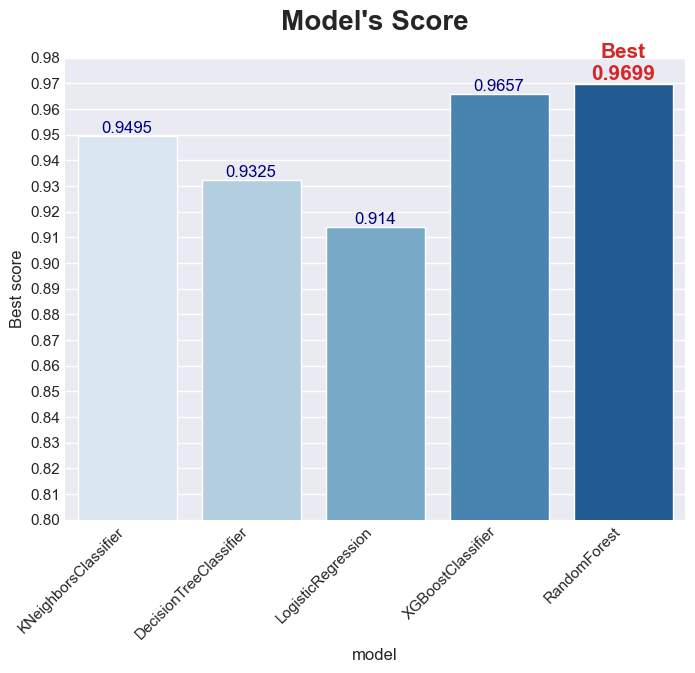

In [664]:
plt.figure(figsize = (8,6))
bar = sns.barplot(data = top20_scores_T, x = "model", y = "Best score", palette = "Blues")
plt.yticks(np.arange(0.8,1,0.01))
plt.xticks(rotation = 45, ha = "right");
plt.ylim(0.8,0.98)

# barplot 수치표시
for i in range(top20_scores_T.shape[0]):
    if i == 4 :
        plt.text(i,top20_scores_T["Best score"][i], f"Best\n{round(top20_scores_T['Best score'][i],4)}", 
                 fontsize = 15, color='tab:red', fontweight = "bold",
                 ha ='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    
    else : 
        plt.text(i,top20_scores_T["Best score"][i], round(top20_scores_T["Best score"][i],4), 
                 fontsize = 12, color='navy', 
                 ha ='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom')    # verticalalignment (top, center, bottom)
        
plt.title("Model's Score",fontweight = "bold", fontsize = 20, pad = 20);

# PCA (Principle Components Analysis)

In [318]:
# pca
X = data.drop("Activity", axis = 1)
y = data[["Activity"]]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 2023, stratify = y)

from sklearn.decomposition import PCA

pca = PCA(n_components = 20)
pca.fit(X_train)

X_pca_train = pca.transform(X_train)
X_pca_val = pca.transform(X_val)

X_train.shape, X_pca_train.shape

((4116, 561), (4116, 20))

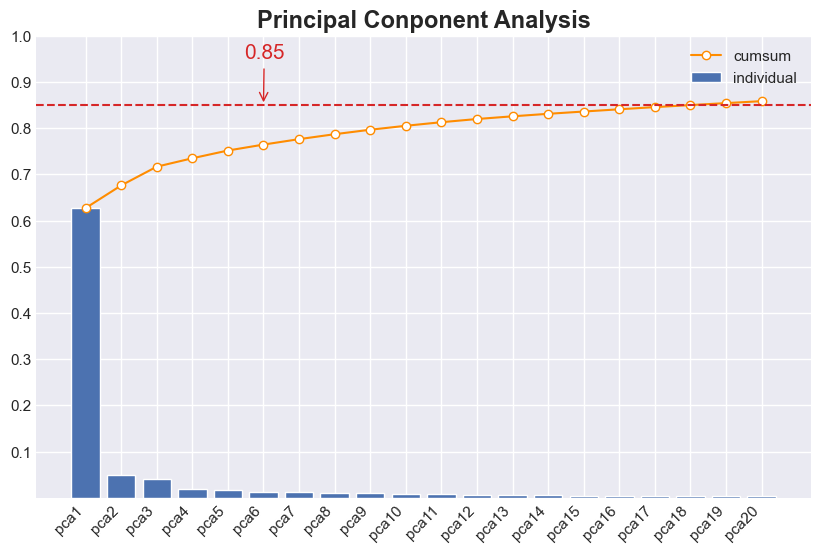

In [528]:
plt.figure(figsize = (10,6))
plt.bar(x  = [f"pca{i}" for i in range(1 ,X_pca_train.shape[1]+1)], height = pca.explained_variance_ratio_, label = "individual")
plt.plot(pca.explained_variance_ratio_.cumsum(), c = "darkorange", marker = "o", markerfacecolor = "white",
         label = "cumsum")
plt.title("Principal Conponent Analysis", fontweight = "bold", fontsize = 17)
plt.xticks(rotation = 45, ha = "right")
plt.yticks(np.arange(0.1,1.1,0.1))
plt.axhline(0.85, ls = "--", color = "tab:red")
plt.annotate("0.85", xy = (5, 0.85), xytext = (4.45, 0.95),color = "tab:red",fontsize = 15,
                 arrowprops = {"arrowstyle":"->","connectionstyle":"arc", "color" : "tab:red"});
plt.legend(loc = "best");

 - 주관적으로 0.85 정도의 데이터 분산 설명도가 합리적이라 판단하여 20개로 정했다.

 - 기본 모델에 pca 20를 넣어서 분석을 진행(그리드 서치를 포함한 하이퍼 파라미터 튜닝)

In [393]:
# 기본 모델들

models = [KNeighborsClassifier(), DecisionTreeClassifier(), 
          LogisticRegression(), RandomForestClassifier()]

param_grids = [{"n_neighbors" : np.arange(1,11)},
               {"max_depth" : np.arange(1,11)},
               {"C" : np.logspace(-3,3,7)},
               {"max_depth" : np.arange(1,15), "max_features" : [2,4,6]}]


pca_scores = pd.DataFrame()

for model, param_grid in zip(models, param_grids):
    gridsearch = GridSearchCV(model, param_grid = param_grid, cv = 3)
    gridsearch.fit(X_pca_train, y_train)
    pca_scores[f"{model}"] = [gridsearch.best_score_, gridsearch.best_params_]
    
pca_scores.index = ["Best score", "Best params"]

In [394]:
pca_scores.T.reset_index(drop = False)
pca_scores_T = pca_scores.T.reset_index(drop = False)
pca_scores_T= pca_scores_T.rename(columns = {"index":"model"})
pca_scores_T.model = pca_scores_T.model.str.slice(start = 0, stop = -2 )

 - xgboost를 진행

In [320]:
# xgboost

mapping = {'STANDING':0, 'SITTING':1, 'LAYING':2, 'WALKING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5}
y_map_train = y_train.replace(mapping)
y_map_val = y_val.replace(mapping)

param_grid = {'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [2,3,4]}

grid_search = GridSearchCV(XGBClassifier(random_state = 2023),
                           param_grid, cv = 3, return_train_score = True, verbose=2)

grid_search.fit(X_pca_train, y_map_train)

print(f"Best Score : {grid_search.best_score_:.2f}")
print("Best params : ", grid_search.best_params_)
print(f"Test Set Score : {grid_search.score(X_pca_val, y_map_val)}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....................learning_rate=0.01, max_depth=2; total time=   1.1s
[CV] END ....................learning_rate=0.01, max_depth=2; total time=   0.9s
[CV] END ....................learning_rate=0.01, max_depth=2; total time=   0.9s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   1.3s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   1.4s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   1.2s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=   1.6s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=   1.9s
[CV] END ....................learning_rate=0.01, max_depth=4; total time=   1.9s
[CV] END .....................learning_rate=0.1, max_depth=2; total time=   1.0s
[CV] END .....................learning_rate=0.1, max_depth=2; total time=   1.1s
[CV] END .....................learning_rate=0.1, 

In [536]:
pca_scores_T.loc[3,:] = ["XGBoostClassifier", grid_search.best_score_, grid_search.best_params_]
pca_scores_T

In [539]:
pca_scores_T

,model,Best score,Best params
0,KNeighborsClassifier,0.913994,{'n_neighbors': 3}
1,DecisionTreeClassifier,0.852527,{'max_depth': 9}
2,LogisticRegression,0.911565,{'C': 1.0}
3,XGBoostClassifier,0.919582,"{'learning_rate': 0.3, 'max_depth': 3}"


 - randomforest 도 진행

In [598]:
X_pca_train.shape, y_train.shape

((4116, 20), (4116, 1))

In [599]:
param_grid = {"max_features": [4], 'max_depth': [None], "n_estimators" : [700]}

grid5 = GridSearchCV(RandomForestClassifier(random_state = 2023),param_grid, cv = 5, return_train_score = True, verbose=2)

grid5.fit(X_pca_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...max_depth=None, max_features=4, n_estimators=700; total time=  12.4s
[CV] END ...max_depth=None, max_features=4, n_estimators=700; total time=  12.2s
[CV] END ...max_depth=None, max_features=4, n_estimators=700; total time=  13.7s
[CV] END ...max_depth=None, max_features=4, n_estimators=700; total time=  13.7s
[CV] END ...max_depth=None, max_features=4, n_estimators=700; total time=  13.5s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2023),
             param_grid={'max_depth': [None], 'max_features': [4],
                         'n_estimators': [700]},
             return_train_score=True, verbose=2)

In [602]:
print(f"Best Score : {grid5.best_score_:.4f}")
print("Best params : ", grid5.best_params_)

Best Score : 0.9159
Best params :  {'max_depth': None, 'max_features': 4, 'n_estimators': 700}


In [603]:
pca_scores_T.loc[4,:] = ["RandomForest", grid5.best_score_, grid5.best_params_]
pca_scores_T

,model,Best score,Best params
0,KNeighborsClassifier,0.913994,{'n_neighbors': 3}
1,DecisionTreeClassifier,0.852527,{'max_depth': 9}
2,LogisticRegression,0.911565,{'C': 1.0}
3,XGBoostClassifier,0.919582,"{'learning_rate': 0.3, 'max_depth': 3}"
4,RandomForest,0.915937,"{'max_depth': None, 'max_features': 4, 'n_esti..."


# 모델 별 점수 시각화

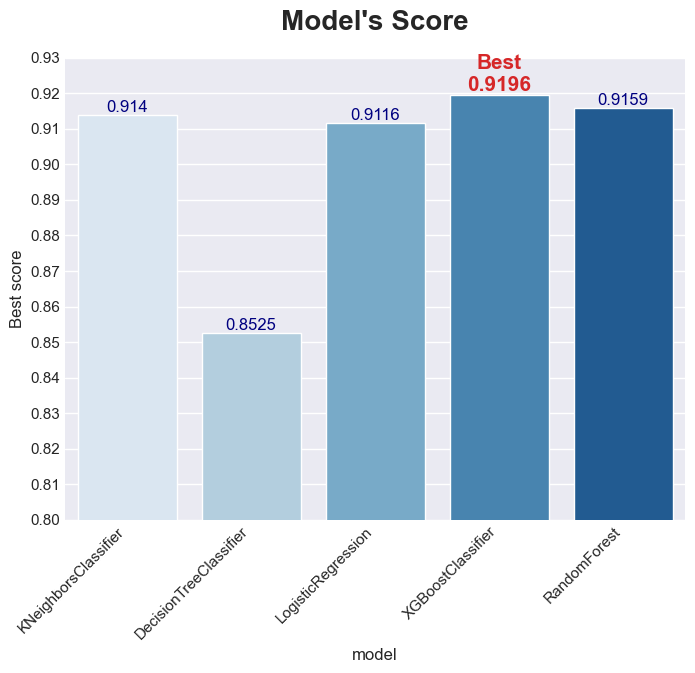

In [604]:
plt.figure(figsize = (8,6))
bar = sns.barplot(data = pca_scores_T, x = "model", y = "Best score", palette = "Blues")
plt.yticks(np.arange(0.8,1,0.01))
plt.xticks(rotation = 45, ha = "right");
plt.ylim(0.8,0.93)

# barplot 수치표시
for i in range(pca_scores_T.shape[0]):
    if i == 3 :
        plt.text(i,pca_scores_T["Best score"][i], f"Best\n{round(pca_scores_T['Best score'][i],4)}", 
                 fontsize = 15, color='tab:red', fontweight = "bold",
                 ha ='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    
    else : 
        plt.text(i,pca_scores_T["Best score"][i], round(pca_scores_T["Best score"][i],4), 
                 fontsize = 12, color='navy', 
                 ha ='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom')    # verticalalignment (top, center, bottom)
        
plt.title("Model's Score",fontweight = "bold", fontsize = 20, pad = 20);

- xgboost가 0.9196으로 제일 좋게 나왔다.

# Isolation Forest

In [26]:
import random

def select_feature(data):
    return random.choice(data.columns)

def select_value(data, feat):
    mini = data[feat].min()
    maxi = data[feat].max()
    return (maxi-mini)*np.random.random()+mini

def split_data(data, split_column, split_value):
    data_below = data[data[split_column] <= split_value]
    data_above = data[data[split_column] > split_value]

    return data_below, data_above

def classify_data(data):

    label_column = data.values[:,]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    return classification

In [27]:
def isolation_tree(data, counter=0, max_depth=50):
    if data.empty ==False: 
        # End Loop if max depth or isolated
        if (counter == max_depth) or data.shape[0] == 1:
            classification = classify_data(data)
            return classification
        else:
            # Counter
            counter += 1

            # Select feature
            split_column = select_feature(data)

            # Select value
            split_value = select_value(data, split_column)
            # Split data
            data_below, data_above = split_data(data, split_column, split_value)

            # instantiate sub-tree
            question = "{} <= {}".format(split_column, split_value)
            sub_tree = {question: []}

            # Recursive part
            below_answer = isolation_tree(data_below, counter, max_depth=max_depth)
            above_answer = isolation_tree(data_above, counter, max_depth=max_depth)

            if below_answer == above_answer:
                sub_tree = below_answer
            else:
                sub_tree[question].append(below_answer)
                sub_tree[question].append(above_answer)

        return sub_tree

In [28]:
def isolation_forest(df, n_trees, max_depth, subspace):
    forest = []
    for i in range(n_trees):
        # Sample the subspace
        if subspace <= 1:
            df = df.sample(frac=subspace)
        else:
            df = df.sample(subspace)
        # Fit tree
        tree = isolation_tree(df, max_depth=max_depth)

        # Save tree to forest
        forest.append(tree)

    return forest

In [29]:
def pathLength(example, iTree, path=0, trace=False):
    # Initialize question and counter
    path = path+1
    question = list(iTree.keys())[0]
    feature_name, comparison_operator, value = question.split()

    # ask question
    if example[feature_name].values <= float(value):
        answer = iTree[question][0]
    else:
        answer = iTree[question][1]

    # base case
    if not isinstance(answer, dict):
        return path

    # recursive part
    else:
        residual_tree = answer
        return pathLength(example, residual_tree, path=path)

    return path

# Evaluate Distance
def evaluate_instance(instance, forest):
    paths = []
    for tree in forest:
        paths.append(pathLength(instance, tree))
    return paths

# C_factor
def c_factor(n):
    return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))

In [30]:
def anomaly_score(data_point, forest, n):

    # Mean depth for an instance
    E = np.mean(evaluate_instance(data_point, forest))

    c = c_factor(n)

    return 2**-(E/c)

In [338]:
# dataframe으로 변경
X_pca_train = pd.DataFrame(X_pca_train, columns = [f"pca{i}" for i in range(1,21)])
X_pca_train

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20
0,-5.715023,1.127761,0.828450,-0.194979,-0.334825,0.874335,0.360906,-0.991548,0.058090,-0.020891,-0.358177,-0.431227,-1.413667,-0.548309,0.475371,0.056835,0.476367,0.421061,0.209654,0.369410
1,5.744226,0.235960,-0.678319,-0.663832,0.996310,0.936813,-0.659103,-0.447525,-0.291780,-0.375749,-0.611740,-0.491867,0.303817,0.208035,-0.403908,-0.356770,-0.505017,-0.380104,0.451877,0.426815
2,4.926150,-0.361756,-0.854238,-1.810360,0.180771,0.345757,-0.100493,0.669622,-0.433182,0.070727,-0.760845,0.396733,-0.317902,-0.119261,-0.735418,-0.216089,-0.527864,-0.804705,0.074068,0.728293
3,9.904746,2.805760,0.534486,0.954015,0.149145,0.410854,-0.819336,0.912477,0.017785,-1.266273,0.269180,0.685371,-0.718142,-0.192335,-0.635557,0.050848,-0.218429,-0.642702,-0.493013,0.280059
4,-6.636184,3.281354,1.631733,-0.220775,-0.179757,0.053616,-0.690598,-1.398101,0.043010,0.577214,-0.733179,-0.894131,-0.413313,-0.084764,0.592180,0.026696,0.042016,-0.005615,0.717785,-0.078857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4111,7.909959,1.401617,-0.164074,0.123667,-0.092424,-0.329378,0.990680,0.686279,0.428322,0.451549,0.212831,-0.145348,0.283191,0.030304,0.331925,0.506952,-0.739279,-1.251174,0.749978,-0.912720
4112,-5.576882,0.291945,-1.513905,0.485012,-0.555196,0.708732,-0.202797,-0.736074,0.050800,-0.121810,-0.186590,0.087610,-0.638998,0.071169,-0.424218,0.182359,0.575299,0.350431,0.015360,0.314518
4113,6.939860,-0.315721,-0.011128,-0.691656,-1.397915,-0.017751,-0.564801,0.249583,-0.046964,-0.763777,-0.179762,0.185661,-0.012272,-0.073610,-0.079382,0.507876,-0.080233,-0.231882,0.558156,-0.895118
4114,12.266688,5.238913,0.498931,0.967903,-1.512314,0.927647,-0.197893,2.339501,1.276127,-0.621547,-0.554640,0.617412,-0.776315,0.394376,0.023842,-0.908712,0.000732,-0.094876,-0.790115,-0.029411


In [339]:
X_pca_train.iloc[:,0]

0       -5.715023
1        5.744226
2        4.926150
3        9.904746
4       -6.636184
          ...    
4111     7.909959
4112    -5.576882
4113     6.939860
4114    12.266688
4115     3.852326
Name: pca1, Length: 4116, dtype: float64

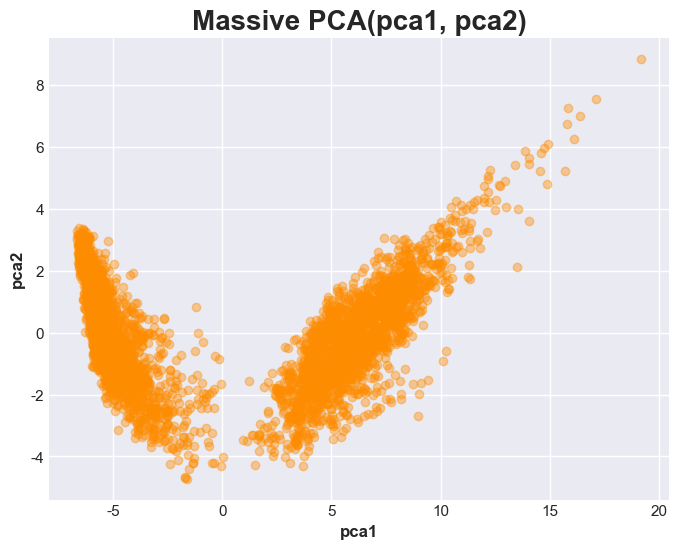

In [341]:
plt.figure(figsize = (8,6))
plt.style.use("seaborn-darkgrid")
plt.scatter(X_pca_train.iloc[:,0], X_pca_train.iloc[:,1],
            color = "darkorange", alpha = 0.4)
plt.xlabel("pca1", fontweight = "bold")
plt.ylabel("pca2", fontweight = "bold")
plt.title("Massive PCA(pca1, pca2)",fontweight = "bold", fontsize = 20);

In [342]:
iForest = isolation_forest(X_pca_train[["pca1", "pca2"]], n_trees=100, max_depth=100, subspace=256)

pred = []
for i in range(X_pca_train.shape[0]):
    pred.append(anomaly_score(X_pca_train.iloc[[i]], iForest, 256))
        
pred = np.array(pred)

In [399]:
# 보통 0~0.5 정상, 0.5~1 이상
(pred > 0.65).sum()

51

In [401]:
predict = np.where(pred < 0.65, 0, 1)

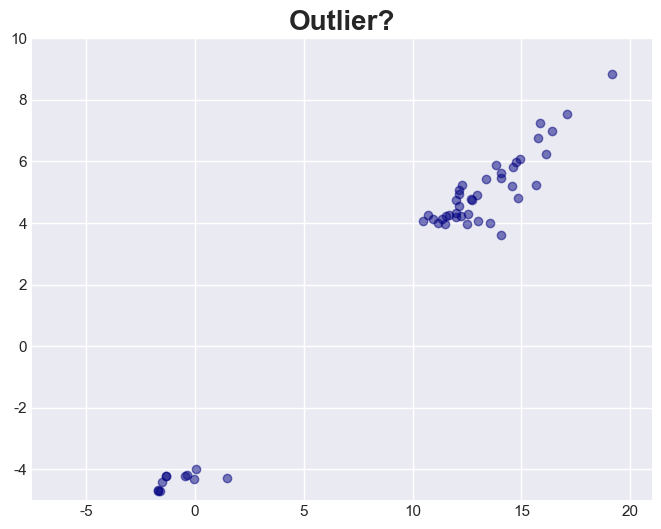

In [402]:
plt.figure(figsize = (8,6))
plt.style.use("seaborn-darkgrid")
plt.scatter(X_pca_train[predict == 1].iloc[:,0], X_pca_train[predict == 1].iloc[:,1],
            color = "navy", alpha = 0.5)
plt.xlim(-7.5, 21)
plt.ylim(-5,10)
plt.title("Outlier?",fontweight = "bold", fontsize = 20);

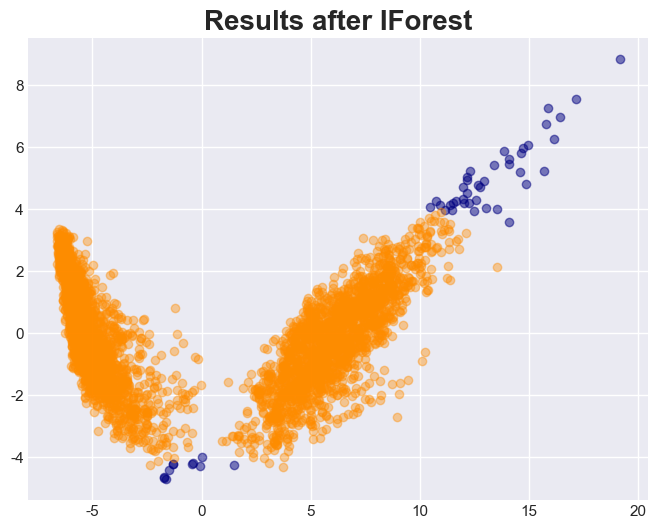

In [403]:
plt.figure(figsize = (8,6))
plt.style.use("seaborn-darkgrid")
plt.scatter(X_pca_train[predict == 1].iloc[:,0], X_pca_train[predict == 1].iloc[:,1],
            color = "navy", alpha = 0.5)
plt.scatter(X_pca_train[predict == 0].iloc[:,0], X_pca_train[predict == 0].iloc[:,1],
            color = "darkorange", alpha = 0.4)
plt.title("Results after iforest",fontweight = "bold", fontsize = 20);

In [404]:
X_iforest = X_pca_train[predict != 1]
y_iforest = y_train[predict != 1]

In [405]:
X_iforest.shape, y_iforest.shape

((4065, 20), (4065, 1))

- 기본 모델

In [545]:
models = [KNeighborsClassifier(), DecisionTreeClassifier(), 
          LogisticRegression(), RandomForestClassifier()]

param_grids = [{"n_neighbors" : np.arange(1,11)},
               {"max_depth" : np.arange(1,11)},
               {"C" : np.logspace(-3,3,7)},
               {"max_depth" : np.arange(1,15), "max_features" : [2,4,6]}]


iforest_scores = pd.DataFrame()

for model, param_grid in zip(models, param_grids):
    gridsearch = GridSearchCV(model, param_grid = param_grid, cv = 3)
    gridsearch.fit(X_iforest, y_iforest)
    iforest_scores[f"{model}"] = [gridsearch.best_score_, gridsearch.best_params_]
    
iforest_scores.index = ["Best score", "Best params"]

In [546]:
iforest_scores_T = iforest_scores.T.reset_index(drop = False)
iforest_scores_T= iforest_scores_T.rename(columns = {"index":"model"})
iforest_scores_T.model = iforest_scores_T.model.str.slice(start = 0, stop = -2 )

 - xgboost

In [410]:
# xgboost
mapping = {'STANDING':0, 'SITTING':1, 'LAYING':2, 'WALKING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5}
y_iforest_map = y_iforest.replace(mapping)


param_grid = {'learning_rate': [0.3], 'max_depth': [3]}

grid3 = GridSearchCV(XGBClassifier(random_state = 2023),
                           param_grid, cv = 3, return_train_score = True, verbose=2)

grid3.fit(X_iforest, y_iforest_map)

print(f"Best Score : {grid3.best_score_:.2f}")
print("Best params : ", grid3.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .....................learning_rate=0.3, max_depth=3; total time=   1.2s
[CV] END .....................learning_rate=0.3, max_depth=3; total time=   1.2s
[CV] END .....................learning_rate=0.3, max_depth=3; total time=   1.3s
Best Score : 0.92
Best params :  {'learning_rate': 0.3, 'max_depth': 3}


In [550]:
iforest_scores_T.loc[3,:] = ["XGBoostClassifier", grid3.best_score_, grid3.best_params_]
iforest_scores_T

,model,Best score,Best params
0,KNeighborsClassifier,0.913407,{'n_neighbors': 3}
1,DecisionTreeClassifier,0.854859,{'max_depth': 9}
2,LogisticRegression,0.912669,{'C': 10.0}
3,XGBoostClassifier,0.915375,"{'learning_rate': 0.3, 'max_depth': 3}"


 - randomforest

In [591]:
param_grid = {"max_features": [4], 'max_depth': [None], "n_estimators" : [700]}
grid6 = GridSearchCV(RandomForestClassifier(random_state = 2023), param_grid, cv = 5, return_train_score = True, verbose=2)
grid6.fit(X_iforest, y_iforest)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...max_depth=None, max_features=4, n_estimators=700; total time=  11.6s
[CV] END ...max_depth=None, max_features=4, n_estimators=700; total time=  11.1s
[CV] END ...max_depth=None, max_features=4, n_estimators=700; total time=  11.2s
[CV] END ...max_depth=None, max_features=4, n_estimators=700; total time=  12.1s
[CV] END ...max_depth=None, max_features=4, n_estimators=700; total time=  11.5s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2023),
             param_grid={'max_depth': [None], 'max_features': [4],
                         'n_estimators': [700]},
             return_train_score=True, verbose=2)

In [595]:
iforest_scores_T.loc[4,:] = ["RandomForest", grid6.best_score_, grid6.best_params_]
iforest_scores_T

,model,Best score by iforest,Best params by iforest
0,KNeighborsClassifier,0.913407,{'n_neighbors': 3}
1,DecisionTreeClassifier,0.854859,{'max_depth': 9}
2,LogisticRegression,0.912669,{'C': 10.0}
3,XGBoostClassifier,0.915375,"{'learning_rate': 0.3, 'max_depth': 3}"
4,RandomForest,0.918573,"{'max_depth': None, 'max_features': 4, 'n_esti..."


# 모델 별 점수 시각화 after iforest

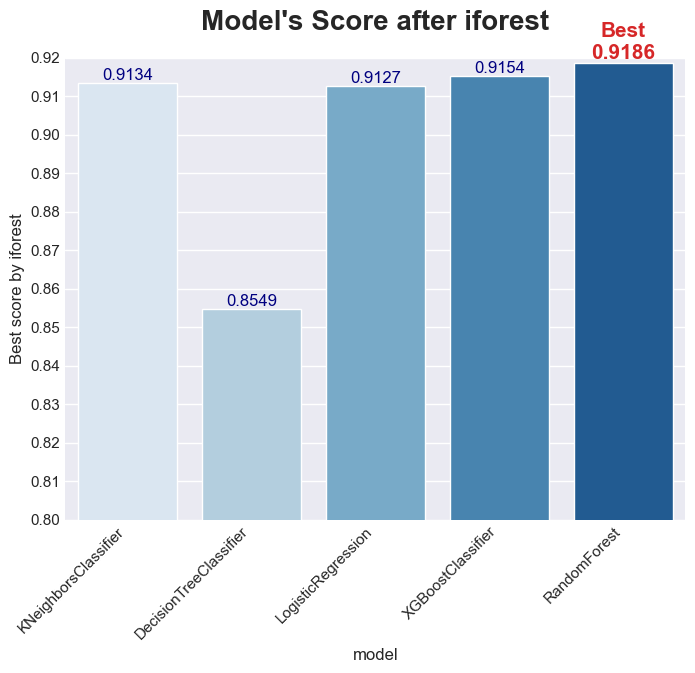

In [597]:
plt.figure(figsize = (8,6))
bar = sns.barplot(data = iforest_scores_T, x = "model", y = "Best score by iforest", palette = "Blues")
plt.yticks(np.arange(0.8,1,0.01))
plt.xticks(rotation = 45, ha = "right");
plt.ylim(0.8,0.92)

# barplot 수치표시
for i in range(iforest_scores_T.shape[0]):
    if i == 4 :
        plt.text(i,iforest_scores_T["Best score by iforest"][i], f"Best\n{round(iforest_scores_T['Best score by iforest'][i],4)}", 
                 fontsize = 15, color='tab:red', fontweight = "bold",
                 ha ='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    
    else : 
        plt.text(i,iforest_scores_T["Best score by iforest"][i], round(iforest_scores_T["Best score by iforest"][i],4), 
                 fontsize = 12, color='navy', 
                 ha ='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom')    # verticalalignment (top, center, bottom)
        
plt.title("Model's Score after iforest",fontweight = "bold", fontsize = 20, pad = 20);

# 함께 비교

In [605]:
iforest_scores_T.columns = ["model", "Best score by iforest", "Best params by iforest"]

In [606]:
all_score = pd.concat([iforest_scores_T.set_index("model"),pca_scores_T.set_index("model")], axis = 1)
all_score.drop(["Best params by iforest", "Best params"], axis = 1)

,Best score by iforest,Best score
model,,
KNeighborsClassifier,0.913407,0.913994
DecisionTreeClassifier,0.854859,0.852527
LogisticRegression,0.912669,0.911565
XGBoostClassifier,0.915375,0.919582
RandomForest,0.918573,0.915937


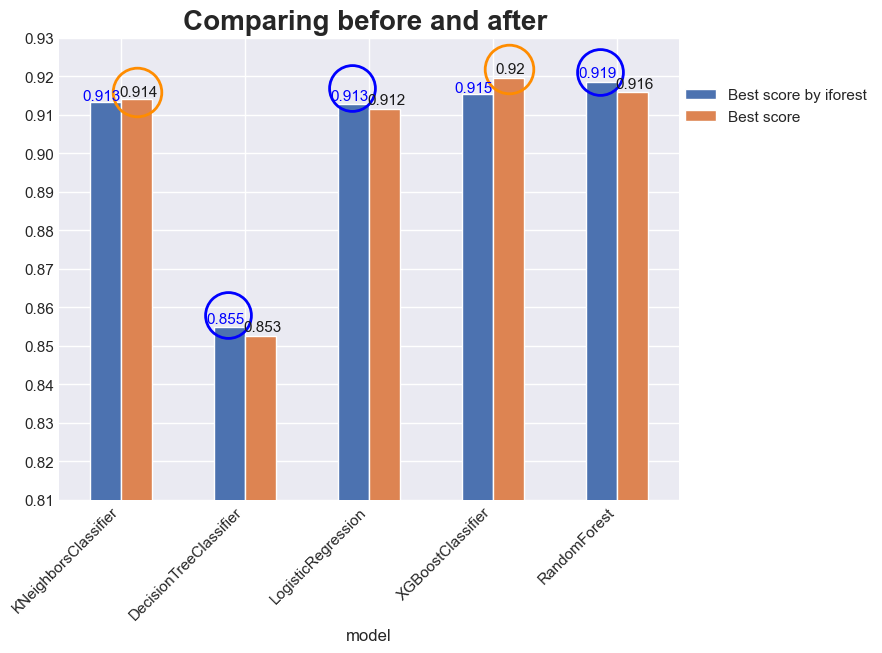

In [609]:
plt.style.use("seaborn-darkgrid")
all_score.plot(kind= "bar", figsize = (8,6))
plt.legend(loc = (1,0.8))
plt.title("")
plt.yticks(np.arange(0.8,1,0.01))
plt.xticks(rotation = 45, ha = "right")
plt.ylim(0.81,0.93)
plt.title("Comparing before and after ",fontweight = "bold", fontsize = 20);

# barplot 수치표시
for i in range(all_score.shape[0]):
    plt.text(i-0.16, round(all_score['Best score by iforest'][i], 3), round(all_score['Best score by iforest'][i], 3),
             fontsize = 11, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    
for i in range(all_score.shape[0]):
    plt.text(i+0.14, round(all_score['Best score'][i], 3), round(all_score['Best score'][i], 3),
             fontsize = 11, 
             color='k',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    
for i in range(all_score.shape[0]):
    if i == 0 or i == 3  : 
        plt.plot(i+0.13, round(all_score['Best score'][i], 3)+0.002, marker = "o",
                 markersize = 35, label = "최적값", fillstyle = "none", c = 'darkorange',
                 mew = 2)
    else : 
        plt.plot(i-0.135, round(all_score['Best score'][i], 3)+0.005, marker = "o",
                 markersize = 33, label = "최적값", fillstyle = "none", c = 'blue',
                 mew = 2)


- iforest 적용 후의 결과가 더 좋다

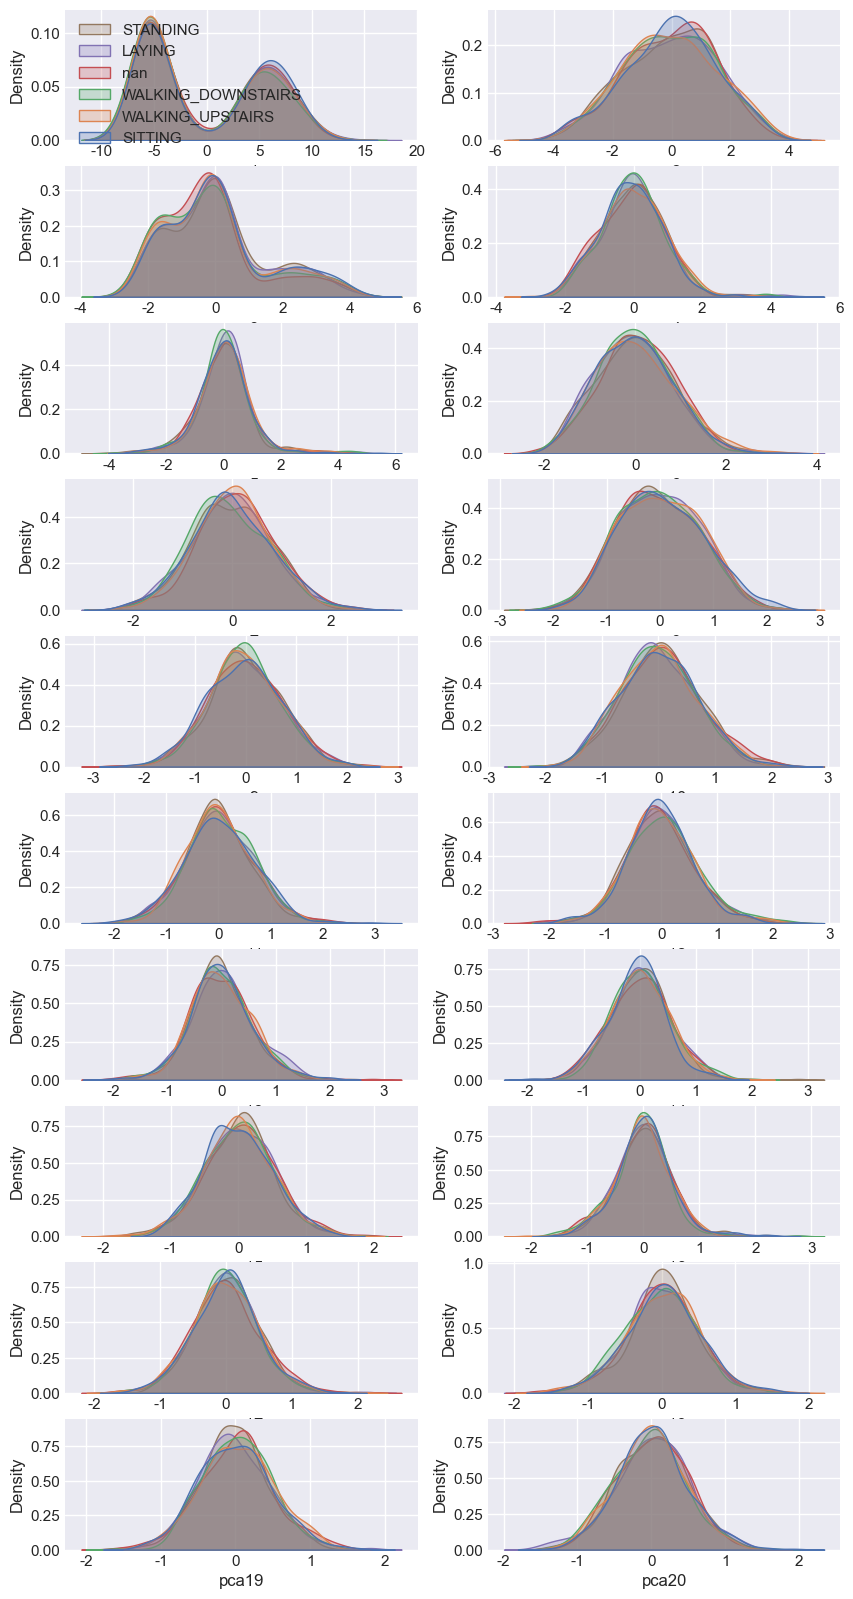

In [610]:
# pca 히스토그램

iforest = pd.concat([X_iforest, y_iforest], axis = 1)

fig,axes = plt.subplots(10,2,figsize = (10,20))

ax = axes.ravel()

for i, name in enumerate(list(X_iforest.columns)):
    if i == 0 :
        sns.kdeplot(data = iforest, x = name, ax = ax[i], 
                    fill = True, hue = "Activity", common_norm = False, legend = True)
        ax[i].legend(list(iforest.Activity.unique()),loc = "upper left")
    else :
        sns.kdeplot(data = iforest, x = name, ax = ax[i], 
                    fill = True, hue = "Activity", common_norm = False, legend = False)

# RandomForest + GridSearchCV

In [558]:
param_grid = {"max_depth" : [10,15,None],
              "n_estimators" : [500, 700, 900],
               "max_features" : [2, 4, 6]}

grid = GridSearchCV(RandomForestClassifier(random_state = 2023), param_grid = param_grid,
                    scoring = "accuracy", cv = 5, return_train_score = True, n_jobs = -1)
grid.fit(X_iforest, y_iforest)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2023),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, None], 'max_features': [2, 4, 6],
                         'n_estimators': [500, 700, 900]},
             return_train_score=True, scoring='accuracy')

In [559]:
grid.cv_results_

{'mean_fit_time': array([11.53233666, 15.44812474, 20.04142194, 16.85744147, 23.93498893,
        28.32633681, 20.86317792, 28.1528265 , 36.93621631,  9.88668675,
        15.24957848, 20.13883796, 19.5763895 , 26.51181402, 33.72508516,
        24.82085977, 35.11513686, 45.97376442, 13.02697558, 17.33802967,
        21.12014279, 17.95126472, 25.75326037, 34.76656656, 24.64963088,
        33.35373926, 34.091714  ]),
 'std_fit_time': array([0.52121475, 0.57593544, 0.61979158, 0.57228247, 1.2455994 ,
        0.66508502, 0.50133974, 0.99828921, 0.82305133, 0.3807718 ,
        0.60987889, 0.57126419, 1.3268478 , 1.47882304, 1.25075034,
        0.56146095, 0.37569037, 0.66619027, 0.70227664, 0.77853001,
        1.04965412, 0.51683531, 0.79262265, 0.56551448, 0.51644545,
        0.5382062 , 4.56001391]),
 'mean_score_time': array([0.42275472, 0.64029913, 0.76025629, 0.37844234, 0.60712442,
        0.61496277, 0.33223438, 0.53873668, 0.64917517, 0.418645  ,
        0.68031178, 0.95173259, 0.652

In [560]:
results = grid.cv_results_["mean_test_score"].reshape(3,3,3,order = "F")

array([[0.89692497, 0.90897909, 0.91193112],
       [0.90184502, 0.91611316, 0.91808118],
       [0.90602706, 0.91439114, 0.91512915]])

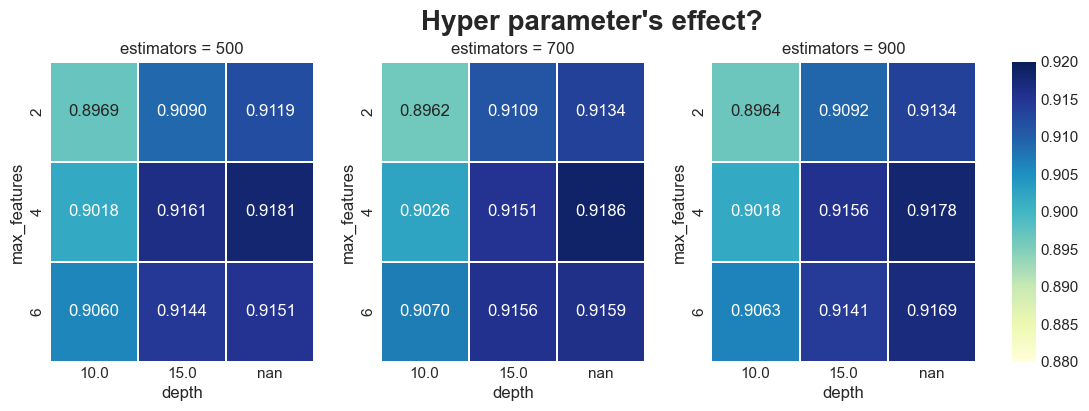

Best params :  {'max_depth': None, 'max_features': 4, 'n_estimators': 700}
Best score : 0.9186


In [562]:
results = grid.cv_results_["mean_test_score"].reshape(3,3,3, order = "F")

fig, axes = plt.subplots(1,3,figsize = (12,4))
axes = axes.ravel()

for i in range(3):
    df = pd.DataFrame(results[i], index = param_grid["max_features"], columns = param_grid["max_depth"])
    sns.heatmap(df, cmap = "YlGnBu", ax = axes[i], vmin = 0.88, vmax = 0.92, cbar = False, lw = 0.2, annot = True,fmt = ".4f")
    axes[i].set_xlabel("depth")
    axes[i].set_ylabel("max_features")
    estimators = param_grid["n_estimators"][i]
    axes[i].set_title(f"estimators = {estimators}")

plt.suptitle("Hyper parameter's effect?",fontweight = "bold", fontsize = 20, ha ="center")

plt.tight_layout()

import matplotlib.cm as cm    
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=0.88, vmax=0.92)

plt.subplots_adjust(wspace = 0.25, bottom=0.1, right= 0.82, top = 0.85)
cax = plt.axes([0.85, 0.1, 0.02, 0.75])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap="YlGnBu"), cax = cax)

plt.show();
print("Best params : ",grid.best_params_)
print(f"Best score : {grid.best_score_:.4f}")
# print(f"Test score : {accuracy_score(y_test, rf_pred):.4f}")

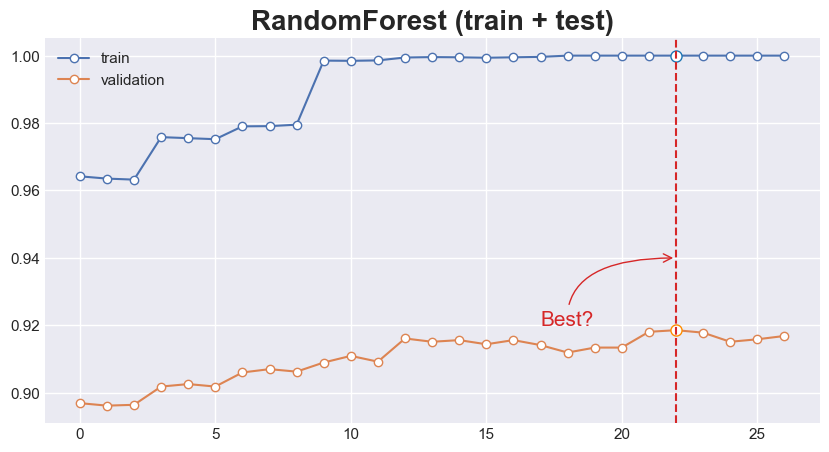

In [509]:
results2 = pd.DataFrame(grid.cv_results_)
best_test_loc = results2.mean_test_score[results2.mean_test_score == grid.best_score_]
best_train_loc = results2.mean_train_score[results2.mean_test_score == grid.best_score_]

plt.figure(figsize = (10,5))
plt.plot(results2.mean_train_score, label = "train",marker = "o", markerfacecolor = "white")
plt.plot(results2.mean_test_score, label = "validation",marker = "o", markerfacecolor = "white")

plt.plot(best_test_loc.index, best_test_loc.values,
         marker = "o",markerfacecolor = "white", markersize = 8, color = "darkorange")

plt.plot(best_train_loc.index, best_train_loc.values,
         marker = "o", markerfacecolor = "white", markersize = 8, color = "tab:blue")
plt.axvline(x = best_train_loc.index, ls = "--", color = "tab:red")
plt.annotate("Best?", xy = (22, 0.94), xytext = (17, 0.92),color = "tab:red",fontsize = 15,
                 arrowprops = {"arrowstyle":"->","connectionstyle":"angle3", "color" : "tab:red"});
plt.title("RandomForest (train + test)", fontsize = 20, fontweight = "bold")
plt.legend(loc = "best")


# # plt.plot(52.8, 0.983, marker = "o", markersize = 60, label = "최적값", fillstyle = "none", c = 'k',mew = 2)
# # plt.text(52.8, 0.942, "Optimization?", ha = "center", fontsize = 15)

In [497]:
grid.cv_results_["mean_test_score"].reshape(3,3,3,order = "F")

array([[[0.89692497, 0.90897909, 0.91193112],
        [0.90184502, 0.91611316, 0.91808118],
        [0.90602706, 0.91439114, 0.91512915]],

       [[0.89618696, 0.91094711, 0.91340713],
        [0.90258303, 0.91512915, 0.91857319],
        [0.90701107, 0.91562116, 0.91586716]],

       [[0.89643296, 0.90922509, 0.91340713],
        [0.90184502, 0.91562116, 0.91783518],
        [0.90627306, 0.91414514, 0.91685117]]])

정확도 : 0.9280


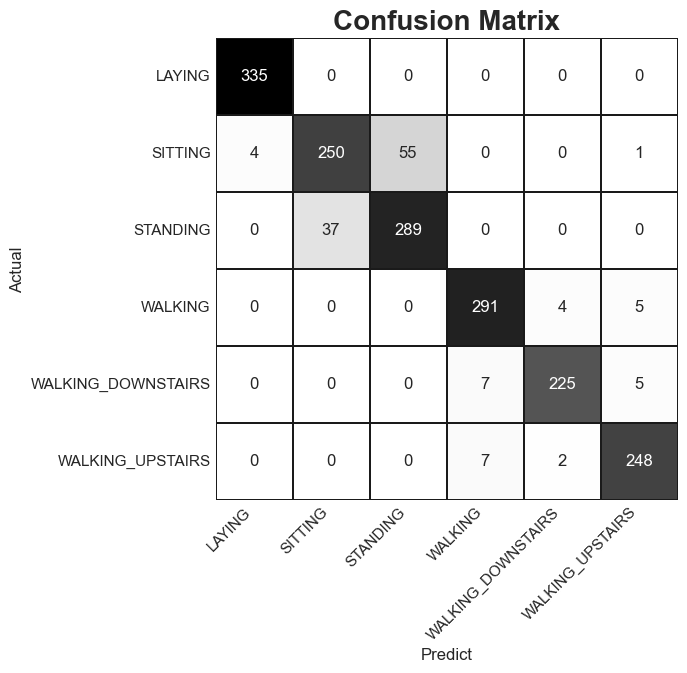

In [498]:
rf_pred = grid.predict(X_pca_test)

print(f"정확도 : {accuracy_score(y_test, rf_pred):.4f}")

cm = pd.crosstab(y_test["Activity"].values , rf_pred)

plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, cmap = "binary", cbar = False, square = True, fmt = "d", lw = 0.2, linecolor = "k" )
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.xticks(rotation = 45, ha = "right")
plt.title("Confusion Matrix",fontweight = "bold", fontsize = 20)


ax = plt.gca()


for label in ["bottom","top","left","right"]:
    ax.spines[label].set_color("k")
    ax.spines[label].set_visible(True)

In [499]:
print(classification_report(y_test, rf_pred))

                    precision    recall  f1-score   support

            LAYING       0.99      1.00      0.99       335
           SITTING       0.87      0.81      0.84       310
          STANDING       0.84      0.89      0.86       326
           WALKING       0.95      0.97      0.96       300
WALKING_DOWNSTAIRS       0.97      0.95      0.96       237
  WALKING_UPSTAIRS       0.96      0.96      0.96       257

          accuracy                           0.93      1765
         macro avg       0.93      0.93      0.93      1765
      weighted avg       0.93      0.93      0.93      1765



# RandomForest의 Ensemble

In [ ]:
rf = RandomForestClassifier(max_depth = None, max_features = 4, n_estimators = 1000,
                            random_state = 2023, n_jobs=-1)


In [ ]:
bagging_predict_result = []
for _ in tqdm(range(100)):
    data_index = [index for index in range(X_iforest.shape[0])]
    
    # 데이터의 인덱스에서 데이터 인덱스의 크기만큼 랜더복원추출
    random_index = np.random.choice(data_index, X_iforest.shape[0])
    print(len(set(random_index)))
    lgb_dtrain = lgb.Dataset(data = X_iforest.iloc[random_index,:],
                             label = lgb_y_train.iloc[random_index])
    lgb_param = {'max_depth': 15, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 500, # Number of trees, 트리 생성 개수
            'objective': 'multiclass',
            'num_class': 6} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
    model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
    
    
    predicts = pd.DataFrame(model.predict(X_pca_test))
    y_pred = list(predicts.apply(lambda x: x.argmax(), axis = 1).values)
    bagging_predict_result.append(y_pred)

# lgboost

In [118]:
import random
import lightgbm as lgb

In [119]:
X_pca_test = pd.DataFrame(X_pca_test, columns = [f"pca{i}" for i in range(1,21)])
X_pca_test

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20
0,5.854278,-3.048888,0.696066,2.075332,1.209923,0.338694,-1.123644,-0.184167,0.461157,1.096794,-0.408017,-0.894262,1.055463,-0.649922,0.309207,0.569448,0.751590,0.158484,0.580336,0.964481
1,6.092546,-0.425602,-0.417707,0.161374,-0.247790,-1.511583,-0.776257,0.319912,-0.862277,-0.723357,-1.611711,0.101185,-0.352110,0.636555,0.863395,-0.757617,-0.245584,-0.842931,-0.711307,0.199963
2,-5.738984,0.756778,-1.617391,0.539392,-0.090922,-0.680767,-0.560019,0.467688,0.045636,-0.817417,0.696693,-0.090827,-0.528904,-0.027126,-0.107230,-0.157750,-0.031795,-0.238982,-0.341219,0.177254
3,2.732291,-2.989643,0.049106,-0.146326,0.508739,0.344384,-1.386263,-0.245125,1.225313,1.033965,0.152433,-0.769850,0.076048,0.241135,-0.720144,-0.214295,-0.449277,0.053900,-0.339685,0.696015
4,-4.504566,-2.817777,0.045512,2.147386,-1.578636,2.036853,0.171756,0.142904,-0.685883,1.123392,-0.404511,-0.301673,0.080669,-0.476432,0.147557,0.281717,-0.096492,0.479823,-0.748490,-0.720100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,-4.963572,-1.683242,0.392547,1.290303,-1.106565,1.397672,0.372550,-0.522386,-0.924606,0.922776,0.152126,-0.417029,-0.239366,0.330642,-0.959552,-0.426767,0.427338,0.414099,0.046895,0.090988
1761,-6.118375,1.446052,3.259246,-0.048326,0.107609,-0.521498,-0.923176,1.034352,-0.699301,0.394980,-0.093770,-0.688067,-0.035998,-1.398126,-0.105540,0.218247,0.447270,-0.018673,0.471629,-0.368689
1762,6.209713,0.478854,-0.335871,-1.080209,-0.839895,-0.845341,0.522107,0.023442,0.619485,-1.012390,-0.139022,-0.263524,0.005169,-0.442686,0.653016,-0.877923,-0.005009,0.486309,0.017986,-0.695149
1763,-1.772105,-2.376120,-0.867669,1.010393,0.353400,-0.230037,1.815019,0.971603,-0.813474,-0.340170,0.750898,-0.790670,0.511374,1.571242,0.819296,-0.387940,-0.171773,-0.427712,-0.024499,0.153655


In [120]:
y_iforest.Activity.unique()

array(['SITTING', 'WALKING', 'LAYING', 'WALKING_UPSTAIRS', 'STANDING',
       'WALKING_DOWNSTAIRS'], dtype=object)

In [121]:
target_replace = {'LAYING':0, 'WALKING':1, 'STANDING':2, 'WALKING_DOWNSTAIRS' : 3, 
                  'SITTING':4, 'WALKING_UPSTAIRS' : 5}

In [122]:
lgb_y_train = y_iforest.replace(target_replace)
lgb_y_test = y_test.replace(target_replace)

In [123]:
import time

start = time.time() # 시작 시간 지정
lgb_dtrain = lgb.Dataset(data = X_iforest, label = lgb_y_train) # 학습 데이터를 LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 500, # Number of trees, 트리 생성 개수
            'objective': 'multiclass',
            'num_class': 6} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
end = time.time()

print("time :", end - start)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.654539
[LightGBM] [Info] Start training from score -1.766220
[LightGBM] [Info] Start training from score -1.675373
[LightGBM] [Info] Start training from score -2.064525
[LightGBM] [Info] Start training from score -1.739210
[LightGBM] [Info] Start training from score -1.910097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
time : 3.262010097503662


In [124]:
predicts = pd.DataFrame(model.predict(X_pca_test))
y_pred = list(predicts.apply(lambda x: x.argmax(), axis = 1).values)
accuracy_score(lgb_y_test, y_pred)

0.9314447592067989

# LGB의 Ensemble

In [91]:
from tqdm import tqdm

In [130]:
bagging_predict_result = []
for _ in tqdm(range(100)):
    data_index = [index for index in range(X_iforest.shape[0])]
    
    # 데이터의 인덱스에서 데이터 인덱스의 크기만큼 랜더복원추출
    random_index = np.random.choice(data_index, X_iforest.shape[0])
    print(len(set(random_index)))
    lgb_dtrain = lgb.Dataset(data = X_iforest.iloc[random_index,:],
                             label = lgb_y_train.iloc[random_index])
    lgb_param = {'max_depth': 15, # 트리 깊이
            'learning_rate': 0.01, # Step Size
            'n_estimators': 500, # Number of trees, 트리 생성 개수
            'objective': 'multiclass',
            'num_class': 6} # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
    model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
    
    
    predicts = pd.DataFrame(model.predict(X_pca_test))
    y_pred = list(predicts.apply(lambda x: x.argmax(), axis = 1).values)
    bagging_predict_result.append(y_pred)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

2533
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.639194
[LightGBM] [Info] Start training from score -1.789545
[LightGBM] [Info] Start training from score -1.692627
[LightGBM] [Info] Start training from score -2.054863
[LightGBM] [Info] Start training from score -1.725283
[LightGBM] [Info] Start training from score -1.906775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  1%|▊                                                                                 | 1/100 [00:03<05:45,  3.49s/it]

2575
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.663601
[LightGBM] [Info] Start training from score -1.674059
[LightGBM] [Info] Start training from score -1.714278
[LightGBM] [Info] Start training from score -2.106156
[LightGBM] [Info] Start training from score -1.749077
[LightGBM] [Info] Start training from score -1.915101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  2%|█▋                                                                                | 2/100 [00:07<06:02,  3.70s/it]

2600
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.685956
[LightGBM] [Info] Start training from score -1.783662
[LightGBM] [Info] Start training from score -1.607961
[LightGBM] [Info] Start training from score -2.074281
[LightGBM] [Info] Start training from score -1.699343
[LightGBM] [Info] Start training from score -1.980755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  3%|██▍                                                                               | 3/100 [00:10<05:42,  3.53s/it]

2576
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.611658
[LightGBM] [Info] Start training from score -1.792499
[LightGBM] [Info] Start training from score -1.683300
[LightGBM] [Info] Start training from score -2.080181
[LightGBM] [Info] Start training from score -1.712911
[LightGBM] [Info] Start training from score -1.945664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  4%|███▎                                                                              | 4/100 [00:14<05:41,  3.56s/it]

2546
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.728053
[LightGBM] [Info] Start training from score -1.730831
[LightGBM] [Info] Start training from score -1.659707
[LightGBM] [Info] Start training from score -2.028296
[LightGBM] [Info] Start training from score -1.715647
[LightGBM] [Info] Start training from score -1.940505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  5%|████                                                                              | 5/100 [00:17<05:31,  3.49s/it]

2577
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.681974
[LightGBM] [Info] Start training from score -1.773451
[LightGBM] [Info] Start training from score -1.693966
[LightGBM] [Info] Start training from score -2.054863
[LightGBM] [Info] Start training from score -1.680651
[LightGBM] [Info] Start training from score -1.923498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  6%|████▉                                                                             | 6/100 [00:20<05:23,  3.44s/it]

2570
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.645559
[LightGBM] [Info] Start training from score -1.795462
[LightGBM] [Info] Start training from score -1.703394
[LightGBM] [Info] Start training from score -2.018976
[LightGBM] [Info] Start training from score -1.722520
[LightGBM] [Info] Start training from score -1.913430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  7%|█████▋                                                                            | 7/100 [00:24<05:19,  3.43s/it]

2590
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.678009
[LightGBM] [Info] Start training from score -1.717018
[LightGBM] [Info] Start training from score -1.651965
[LightGBM] [Info] Start training from score -2.047200
[LightGBM] [Info] Start training from score -1.767662
[LightGBM] [Info] Start training from score -1.950850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  8%|██████▌                                                                           | 8/100 [00:27<05:13,  3.41s/it]

2575
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.649398
[LightGBM] [Info] Start training from score -1.773451
[LightGBM] [Info] Start training from score -1.667510
[LightGBM] [Info] Start training from score -2.110213
[LightGBM] [Info] Start training from score -1.726667
[LightGBM] [Info] Start training from score -1.895233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  9%|███████▍                                                                          | 9/100 [00:31<05:08,  3.39s/it]

2570
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.679329
[LightGBM] [Info] Start training from score -1.729441
[LightGBM] [Info] Start training from score -1.650681
[LightGBM] [Info] Start training from score -2.035815
[LightGBM] [Info] Start training from score -1.776358
[LightGBM] [Info] Start training from score -1.935372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 10%|████████                                                                         | 10/100 [00:34<05:10,  3.45s/it]

2542
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.650681
[LightGBM] [Info] Start training from score -1.737809
[LightGBM] [Info] Start training from score -1.746248
[LightGBM] [Info] Start training from score -2.030170
[LightGBM] [Info] Start training from score -1.739210
[LightGBM] [Info] Start training from score -1.891960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 11%|████████▉                                                                        | 11/100 [00:38<05:11,  3.50s/it]

2586
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.739210
[LightGBM] [Info] Start training from score -1.814938
[LightGBM] [Info] Start training from score -1.650681
[LightGBM] [Info] Start training from score -2.045294
[LightGBM] [Info] Start training from score -1.693966
[LightGBM] [Info] Start training from score -1.855067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 12%|█████████▋                                                                       | 12/100 [00:41<05:07,  3.50s/it]

2543
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.670124
[LightGBM] [Info] Start training from score -1.807402
[LightGBM] [Info] Start training from score -1.646837
[LightGBM] [Info] Start training from score -2.018976
[LightGBM] [Info] Start training from score -1.737809
[LightGBM] [Info] Start training from score -1.921813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 13%|██████████▌                                                                      | 13/100 [00:45<05:07,  3.54s/it]

2584
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.661004
[LightGBM] [Info] Start training from score -1.722520
[LightGBM] [Info] Start training from score -1.667510
[LightGBM] [Info] Start training from score -2.106156
[LightGBM] [Info] Start training from score -1.750494
[LightGBM] [Info] Start training from score -1.915101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 14%|███████████▎                                                                     | 14/100 [00:48<05:03,  3.53s/it]

2593
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.640464
[LightGBM] [Info] Start training from score -1.737809
[LightGBM] [Info] Start training from score -1.703394
[LightGBM] [Info] Start training from score -2.086116
[LightGBM] [Info] Start training from score -1.751914
[LightGBM] [Info] Start training from score -1.893595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 15%|████████████▏                                                                    | 15/100 [00:52<05:11,  3.67s/it]

2564
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.609192
[LightGBM] [Info] Start training from score -1.717018
[LightGBM] [Info] Start training from score -1.680651
[LightGBM] [Info] Start training from score -2.020833
[LightGBM] [Info] Start training from score -1.756184
[LightGBM] [Info] Start training from score -2.049110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 16%|████████████▉                                                                    | 16/100 [00:56<05:17,  3.78s/it]

2563
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.733616
[LightGBM] [Info] Start training from score -1.743427
[LightGBM] [Info] Start training from score -1.636659
[LightGBM] [Info] Start training from score -1.980755
[LightGBM] [Info] Start training from score -1.792499
[LightGBM] [Info] Start training from score -1.901812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 17%|█████████████▊                                                                   | 17/100 [01:01<05:26,  3.93s/it]

2550
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.650681
[LightGBM] [Info] Start training from score -1.744836
[LightGBM] [Info] Start training from score -1.732222
[LightGBM] [Info] Start training from score -2.104134
[LightGBM] [Info] Start training from score -1.743427
[LightGBM] [Info] Start training from score -1.834801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 18%|██████████████▌                                                                  | 18/100 [01:05<05:28,  4.00s/it]

2530
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.645559
[LightGBM] [Info] Start training from score -1.746248
[LightGBM] [Info] Start training from score -1.685956
[LightGBM] [Info] Start training from score -2.110213
[LightGBM] [Info] Start training from score -1.764780
[LightGBM] [Info] Start training from score -1.864561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 19%|███████████████▍                                                                 | 19/100 [01:09<05:30,  4.08s/it]

2581
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.683300
[LightGBM] [Info] Start training from score -1.802908
[LightGBM] [Info] Start training from score -1.700691
[LightGBM] [Info] Start training from score -1.995144
[LightGBM] [Info] Start training from score -1.655829
[LightGBM] [Info] Start training from score -1.966570
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 20%|████████████████▏                                                                | 20/100 [01:13<05:29,  4.12s/it]

2539
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.663601
[LightGBM] [Info] Start training from score -1.856643
[LightGBM] [Info] Start training from score -1.676690
[LightGBM] [Info] Start training from score -2.058717
[LightGBM] [Info] Start training from score -1.678009
[LightGBM] [Info] Start training from score -1.877361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 21%|█████████████████                                                                | 21/100 [01:18<05:28,  4.16s/it]

2589
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.702042
[LightGBM] [Info] Start training from score -1.696651
[LightGBM] [Info] Start training from score -1.747661
[LightGBM] [Info] Start training from score -2.024558
[LightGBM] [Info] Start training from score -1.732222
[LightGBM] [Info] Start training from score -1.888697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 22%|█████████████████▊                                                               | 22/100 [01:22<05:27,  4.20s/it]

2533
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.653252
[LightGBM] [Info] Start training from score -1.782197
[LightGBM] [Info] Start training from score -1.715647
[LightGBM] [Info] Start training from score -1.995144
[LightGBM] [Info] Start training from score -1.742019
[LightGBM] [Info] Start training from score -1.901812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 23%|██████████████████▋                                                              | 23/100 [01:26<05:25,  4.23s/it]

2581
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.626583
[LightGBM] [Info] Start training from score -1.795462
[LightGBM] [Info] Start training from score -1.654539
[LightGBM] [Info] Start training from score -2.074281
[LightGBM] [Info] Start training from score -1.767662
[LightGBM] [Info] Start training from score -1.898517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 24%|███████████████████▍                                                             | 24/100 [01:30<05:20,  4.22s/it]

2565
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.659707
[LightGBM] [Info] Start training from score -1.718391
[LightGBM] [Info] Start training from score -1.676690
[LightGBM] [Info] Start training from score -2.106156
[LightGBM] [Info] Start training from score -1.739210
[LightGBM] [Info] Start training from score -1.923498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 25%|████████████████████▎                                                            | 25/100 [01:35<05:15,  4.20s/it]

2560
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.670124
[LightGBM] [Info] Start training from score -1.783662
[LightGBM] [Info] Start training from score -1.607961
[LightGBM] [Info] Start training from score -2.130748
[LightGBM] [Info] Start training from score -1.732222
[LightGBM] [Info] Start training from score -1.911762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 26%|█████████████████████                                                            | 26/100 [01:39<05:18,  4.30s/it]

2566
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.654539
[LightGBM] [Info] Start training from score -1.799923
[LightGBM] [Info] Start training from score -1.659707
[LightGBM] [Info] Start training from score -2.060649
[LightGBM] [Info] Start training from score -1.736409
[LightGBM] [Info] Start training from score -1.898517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 27%|█████████████████████▊                                                           | 27/100 [01:44<05:16,  4.34s/it]

2580
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.644283
[LightGBM] [Info] Start training from score -1.822531
[LightGBM] [Info] Start training from score -1.695308
[LightGBM] [Info] Start training from score -2.032048
[LightGBM] [Info] Start training from score -1.751914
[LightGBM] [Info] Start training from score -1.850354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 28%|██████████████████████▋                                                          | 28/100 [01:48<05:11,  4.33s/it]

2567
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.676690
[LightGBM] [Info] Start training from score -1.769106
[LightGBM] [Info] Start training from score -1.645559
[LightGBM] [Info] Start training from score -2.054863
[LightGBM] [Info] Start training from score -1.785130
[LightGBM] [Info] Start training from score -1.872542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 29%|███████████████████████▍                                                         | 29/100 [01:52<05:09,  4.36s/it]

2536
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.649398
[LightGBM] [Info] Start training from score -1.804404
[LightGBM] [Info] Start training from score -1.681974
[LightGBM] [Info] Start training from score -2.004243
[LightGBM] [Info] Start training from score -1.773451
[LightGBM] [Info] Start training from score -1.878972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 30%|████████████████████████▎                                                        | 30/100 [01:56<05:01,  4.31s/it]

2576
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.651965
[LightGBM] [Info] Start training from score -1.692627
[LightGBM] [Info] Start training from score -1.704748
[LightGBM] [Info] Start training from score -2.199444
[LightGBM] [Info] Start training from score -1.722520
[LightGBM] [Info] Start training from score -1.877361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 31%|█████████████████████████                                                        | 31/100 [02:01<04:52,  4.24s/it]

2590
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.627837
[LightGBM] [Info] Start training from score -1.830182
[LightGBM] [Info] Start training from score -1.674059
[LightGBM] [Info] Start training from score -2.015273
[LightGBM] [Info] Start training from score -1.783662
[LightGBM] [Info] Start training from score -1.867745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 32%|█████████████████████████▉                                                       | 32/100 [02:05<04:48,  4.24s/it]

2548
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.684627
[LightGBM] [Info] Start training from score -1.733616
[LightGBM] [Info] Start training from score -1.641735
[LightGBM] [Info] Start training from score -2.120428
[LightGBM] [Info] Start training from score -1.723901
[LightGBM] [Info] Start training from score -1.925185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 33%|██████████████████████████▋                                                      | 33/100 [02:09<04:43,  4.22s/it]

2573
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.653252
[LightGBM] [Info] Start training from score -1.772000
[LightGBM] [Info] Start training from score -1.688619
[LightGBM] [Info] Start training from score -2.006073
[LightGBM] [Info] Start training from score -1.769106
[LightGBM] [Info] Start training from score -1.905118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 34%|███████████████████████████▌                                                     | 34/100 [02:13<04:39,  4.23s/it]

2565
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.659707
[LightGBM] [Info] Start training from score -1.776358
[LightGBM] [Info] Start training from score -1.687286
[LightGBM] [Info] Start training from score -2.064525
[LightGBM] [Info] Start training from score -1.707462
[LightGBM] [Info] Start training from score -1.915101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 35%|████████████████████████████▎                                                    | 35/100 [02:17<04:32,  4.20s/it]

2545
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.627837
[LightGBM] [Info] Start training from score -1.833259
[LightGBM] [Info] Start training from score -1.629093
[LightGBM] [Info] Start training from score -2.000593
[LightGBM] [Info] Start training from score -1.746248
[LightGBM] [Info] Start training from score -1.980755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

 36%|█████████████████████████████▏                                                   | 36/100 [02:22<04:28,  4.20s/it]

2561
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.644283
[LightGBM] [Info] Start training from score -1.825585
[LightGBM] [Info] Start training from score -1.667510
[LightGBM] [Info] Start training from score -2.088102
[LightGBM] [Info] Start training from score -1.721142
[LightGBM] [Info] Start training from score -1.869342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 37%|█████████████████████████████▉                                                   | 37/100 [02:26<04:21,  4.16s/it]

2577
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.655829
[LightGBM] [Info] Start training from score -1.747661
[LightGBM] [Info] Start training from score -1.718391
[LightGBM] [Info] Start training from score -2.076244
[LightGBM] [Info] Start training from score -1.769106
[LightGBM] [Info] Start training from score -1.834801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 38%|██████████████████████████████▊                                                  | 38/100 [02:30<04:14,  4.11s/it]

2568
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.632869
[LightGBM] [Info] Start training from score -1.729441
[LightGBM] [Info] Start training from score -1.666205
[LightGBM] [Info] Start training from score -2.082155
[LightGBM] [Info] Start training from score -1.735012
[LightGBM] [Info] Start training from score -1.986127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 39%|███████████████████████████████▌                                                 | 39/100 [02:34<04:22,  4.30s/it]

2588
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.643008
[LightGBM] [Info] Start training from score -1.749077
[LightGBM] [Info] Start training from score -1.710183
[LightGBM] [Info] Start training from score -2.052942
[LightGBM] [Info] Start training from score -1.710183
[LightGBM] [Info] Start training from score -1.947389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 40%|████████████████████████████████▍                                                | 40/100 [02:38<04:11,  4.20s/it]

2598
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.636659
[LightGBM] [Info] Start training from score -1.761907
[LightGBM] [Info] Start training from score -1.685956
[LightGBM] [Info] Start training from score -2.049110
[LightGBM] [Info] Start training from score -1.760473
[LightGBM] [Info] Start training from score -1.913430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 41%|█████████████████████████████████▏                                               | 41/100 [02:43<04:09,  4.22s/it]

2572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.668816
[LightGBM] [Info] Start training from score -1.802908
[LightGBM] [Info] Start training from score -1.722520
[LightGBM] [Info] Start training from score -1.998774
[LightGBM] [Info] Start training from score -1.726667
[LightGBM] [Info] Start training from score -1.866152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 42%|██████████████████████████████████                                               | 42/100 [02:47<04:05,  4.24s/it]

2561
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.657120
[LightGBM] [Info] Start training from score -1.796947
[LightGBM] [Info] Start training from score -1.643008
[LightGBM] [Info] Start training from score -2.043391
[LightGBM] [Info] Start training from score -1.786599
[LightGBM] [Info] Start training from score -1.877361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 43%|██████████████████████████████████▊                                              | 43/100 [02:52<04:20,  4.56s/it]

2570
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.614130
[LightGBM] [Info] Start training from score -1.814938
[LightGBM] [Info] Start training from score -1.643008
[LightGBM] [Info] Start training from score -2.100102
[LightGBM] [Info] Start training from score -1.776358
[LightGBM] [Info] Start training from score -1.877361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 44%|███████████████████████████████████▋                                             | 44/100 [02:56<04:08,  4.44s/it]

2539
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.640464
[LightGBM] [Info] Start training from score -1.735012
[LightGBM] [Info] Start training from score -1.671434
[LightGBM] [Info] Start training from score -2.064525
[LightGBM] [Info] Start training from score -1.793979
[LightGBM] [Info] Start training from score -1.906775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 45%|████████████████████████████████████▍                                            | 45/100 [03:01<04:02,  4.40s/it]

2563
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.640464
[LightGBM] [Info] Start training from score -1.789545
[LightGBM] [Info] Start training from score -1.617850
[LightGBM] [Info] Start training from score -2.102116
[LightGBM] [Info] Start training from score -1.780734
[LightGBM] [Info] Start training from score -1.896874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 46%|█████████████████████████████████████▎                                           | 46/100 [03:05<04:01,  4.47s/it]

2553
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.670124
[LightGBM] [Info] Start training from score -1.714278
[LightGBM] [Info] Start training from score -1.643008
[LightGBM] [Info] Start training from score -2.106156
[LightGBM] [Info] Start training from score -1.792499
[LightGBM] [Info] Start training from score -1.896874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 47%|██████████████████████████████████████                                           | 47/100 [03:10<04:01,  4.56s/it]

2557
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.663601
[LightGBM] [Info] Start training from score -1.735012
[LightGBM] [Info] Start training from score -1.707462
[LightGBM] [Info] Start training from score -2.064525
[LightGBM] [Info] Start training from score -1.730831
[LightGBM] [Info] Start training from score -1.905118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 48%|██████████████████████████████████████▉                                          | 48/100 [03:14<03:53,  4.49s/it]

2560
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.640464
[LightGBM] [Info] Start training from score -1.782197
[LightGBM] [Info] Start training from score -1.639194
[LightGBM] [Info] Start training from score -2.088102
[LightGBM] [Info] Start training from score -1.729441
[LightGBM] [Info] Start training from score -1.949118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 49%|███████████████████████████████████████▋                                         | 49/100 [03:19<03:44,  4.41s/it]

2560
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.635394
[LightGBM] [Info] Start training from score -1.799923
[LightGBM] [Info] Start training from score -1.739210
[LightGBM] [Info] Start training from score -2.024558
[LightGBM] [Info] Start training from score -1.685956
[LightGBM] [Info] Start training from score -1.918451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 50%|████████████████████████████████████████▌                                        | 50/100 [03:23<03:36,  4.33s/it]

2533
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.640464
[LightGBM] [Info] Start training from score -1.717018
[LightGBM] [Info] Start training from score -1.730831
[LightGBM] [Info] Start training from score -2.092086
[LightGBM] [Info] Start training from score -1.753335
[LightGBM] [Info] Start training from score -1.878972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 51%|█████████████████████████████████████████▎                                       | 51/100 [03:27<03:26,  4.20s/it]

2561
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.654539
[LightGBM] [Info] Start training from score -1.761907
[LightGBM] [Info] Start training from score -1.678009
[LightGBM] [Info] Start training from score -2.074281
[LightGBM] [Info] Start training from score -1.742019
[LightGBM] [Info] Start training from score -1.900163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 52%|██████████████████████████████████████████                                       | 52/100 [03:31<03:17,  4.11s/it]

2540
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.729441
[LightGBM] [Info] Start training from score -1.766220
[LightGBM] [Info] Start training from score -1.649398
[LightGBM] [Info] Start training from score -1.961303
[LightGBM] [Info] Start training from score -1.739210
[LightGBM] [Info] Start training from score -1.943941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:35<03:14,  4.13s/it]

2562
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.671434
[LightGBM] [Info] Start training from score -1.763342
[LightGBM] [Info] Start training from score -1.662301
[LightGBM] [Info] Start training from score -2.084133
[LightGBM] [Info] Start training from score -1.733616
[LightGBM] [Info] Start training from score -1.898517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:39<03:09,  4.11s/it]

2553
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.624080
[LightGBM] [Info] Start training from score -1.746248
[LightGBM] [Info] Start training from score -1.679329
[LightGBM] [Info] Start training from score -2.116329
[LightGBM] [Info] Start training from score -1.757612
[LightGBM] [Info] Start training from score -1.903463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 55%|████████████████████████████████████████████▌                                    | 55/100 [03:43<03:06,  4.15s/it]

2565
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.629093
[LightGBM] [Info] Start training from score -1.777814
[LightGBM] [Info] Start training from score -1.708821
[LightGBM] [Info] Start training from score -2.100102
[LightGBM] [Info] Start training from score -1.699343
[LightGBM] [Info] Start training from score -1.906775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:47<03:03,  4.18s/it]

2557
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.616608
[LightGBM] [Info] Start training from score -1.707462
[LightGBM] [Info] Start training from score -1.655829
[LightGBM] [Info] Start training from score -2.186199
[LightGBM] [Info] Start training from score -1.761907
[LightGBM] [Info] Start training from score -1.930266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:52<03:01,  4.22s/it]

2594
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.676690
[LightGBM] [Info] Start training from score -1.792499
[LightGBM] [Info] Start training from score -1.659707
[LightGBM] [Info] Start training from score -2.098092
[LightGBM] [Info] Start training from score -1.725283
[LightGBM] [Info] Start training from score -1.861386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:56<02:58,  4.25s/it]

2555
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.675373
[LightGBM] [Info] Start training from score -1.749077
[LightGBM] [Info] Start training from score -1.680651
[LightGBM] [Info] Start training from score -2.114287
[LightGBM] [Info] Start training from score -1.739210
[LightGBM] [Info] Start training from score -1.856643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:00<02:53,  4.23s/it]

2581
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.674059
[LightGBM] [Info] Start training from score -1.744836
[LightGBM] [Info] Start training from score -1.666205
[LightGBM] [Info] Start training from score -2.047200
[LightGBM] [Info] Start training from score -1.776358
[LightGBM] [Info] Start training from score -1.893595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 60%|████████████████████████████████████████████████▌                                | 60/100 [04:04<02:48,  4.22s/it]

2572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.681974
[LightGBM] [Info] Start training from score -1.692627
[LightGBM] [Info] Start training from score -1.725283
[LightGBM] [Info] Start training from score -2.049110
[LightGBM] [Info] Start training from score -1.744836
[LightGBM] [Info] Start training from score -1.908434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 61%|█████████████████████████████████████████████████▍                               | 61/100 [04:08<02:41,  4.14s/it]

2524
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.595736
[LightGBM] [Info] Start training from score -1.836346
[LightGBM] [Info] Start training from score -1.653252
[LightGBM] [Info] Start training from score -2.134906
[LightGBM] [Info] Start training from score -1.718391
[LightGBM] [Info] Start training from score -1.905118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 62%|██████████████████████████████████████████████████▏                              | 62/100 [04:13<02:39,  4.20s/it]

2557
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.610424
[LightGBM] [Info] Start training from score -1.747661
[LightGBM] [Info] Start training from score -1.662301
[LightGBM] [Info] Start training from score -2.134906
[LightGBM] [Info] Start training from score -1.735012
[LightGBM] [Info] Start training from score -1.954322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 63%|███████████████████████████████████████████████████                              | 63/100 [04:17<02:38,  4.28s/it]

2575
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.721142
[LightGBM] [Info] Start training from score -1.773451
[LightGBM] [Info] Start training from score -1.658413
[LightGBM] [Info] Start training from score -2.024558
[LightGBM] [Info] Start training from score -1.760473
[LightGBM] [Info] Start training from score -1.851922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:22<02:36,  4.34s/it]

2582
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.640464
[LightGBM] [Info] Start training from score -1.782197
[LightGBM] [Info] Start training from score -1.661004
[LightGBM] [Info] Start training from score -2.052942
[LightGBM] [Info] Start training from score -1.733616
[LightGBM] [Info] Start training from score -1.945664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:26<02:35,  4.43s/it]

2565
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.692627
[LightGBM] [Info] Start training from score -1.712911
[LightGBM] [Info] Start training from score -1.687286
[LightGBM] [Info] Start training from score -2.104134
[LightGBM] [Info] Start training from score -1.722520
[LightGBM] [Info] Start training from score -1.896874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:30<02:29,  4.39s/it]

2570
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.607961
[LightGBM] [Info] Start training from score -1.825585
[LightGBM] [Info] Start training from score -1.678009
[LightGBM] [Info] Start training from score -2.102116
[LightGBM] [Info] Start training from score -1.728053
[LightGBM] [Info] Start training from score -1.883823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:35<02:28,  4.50s/it]

2548
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.590887
[LightGBM] [Info] Start training from score -1.780734
[LightGBM] [Info] Start training from score -1.679329
[LightGBM] [Info] Start training from score -2.054863
[LightGBM] [Info] Start training from score -1.785130
[LightGBM] [Info] Start training from score -1.928569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:40<02:23,  4.48s/it]

2560
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.663601
[LightGBM] [Info] Start training from score -1.799923
[LightGBM] [Info] Start training from score -1.711546
[LightGBM] [Info] Start training from score -2.043391
[LightGBM] [Info] Start training from score -1.772000
[LightGBM] [Info] Start training from score -1.801414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:44<02:19,  4.48s/it]

2530
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.603053
[LightGBM] [Info] Start training from score -1.814938
[LightGBM] [Info] Start training from score -1.654539
[LightGBM] [Info] Start training from score -2.052942
[LightGBM] [Info] Start training from score -1.769106
[LightGBM] [Info] Start training from score -1.925185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:48<02:12,  4.41s/it]

2553
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.671434
[LightGBM] [Info] Start training from score -1.816452
[LightGBM] [Info] Start training from score -1.658413
[LightGBM] [Info] Start training from score -2.047200
[LightGBM] [Info] Start training from score -1.697996
[LightGBM] [Info] Start training from score -1.918451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [04:53<02:05,  4.34s/it]

2598
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.708821
[LightGBM] [Info] Start training from score -1.744836
[LightGBM] [Info] Start training from score -1.689953
[LightGBM] [Info] Start training from score -2.070367
[LightGBM] [Info] Start training from score -1.710183
[LightGBM] [Info] Start training from score -1.878972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [04:57<01:59,  4.27s/it]

2593
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.619093
[LightGBM] [Info] Start training from score -1.750494
[LightGBM] [Info] Start training from score -1.697996
[LightGBM] [Info] Start training from score -2.052942
[LightGBM] [Info] Start training from score -1.777814
[LightGBM] [Info] Start training from score -1.911762
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:01<01:56,  4.31s/it]

2567
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.661004
[LightGBM] [Info] Start training from score -1.772000
[LightGBM] [Info] Start training from score -1.634131
[LightGBM] [Info] Start training from score -2.051024
[LightGBM] [Info] Start training from score -1.782197
[LightGBM] [Info] Start training from score -1.910097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:05<01:51,  4.27s/it]

2581
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.672745
[LightGBM] [Info] Start training from score -1.711546
[LightGBM] [Info] Start training from score -1.611658
[LightGBM] [Info] Start training from score -2.094084
[LightGBM] [Info] Start training from score -1.756184
[LightGBM] [Info] Start training from score -1.993334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [05:10<01:47,  4.28s/it]

2574
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.706104
[LightGBM] [Info] Start training from score -1.754759
[LightGBM] [Info] Start training from score -1.594521
[LightGBM] [Info] Start training from score -2.045294
[LightGBM] [Info] Start training from score -1.769106
[LightGBM] [Info] Start training from score -1.947389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [05:14<01:44,  4.35s/it]

2576
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.675373
[LightGBM] [Info] Start training from score -1.821008
[LightGBM] [Info] Start training from score -1.710183
[LightGBM] [Info] Start training from score -2.024558
[LightGBM] [Info] Start training from score -1.693966
[LightGBM] [Info] Start training from score -1.869342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:18<01:38,  4.29s/it]

2527
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.609192
[LightGBM] [Info] Start training from score -1.759041
[LightGBM] [Info] Start training from score -1.725283
[LightGBM] [Info] Start training from score -2.062585
[LightGBM] [Info] Start training from score -1.792499
[LightGBM] [Info] Start training from score -1.858221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [05:23<01:34,  4.28s/it]

2580
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.693966
[LightGBM] [Info] Start training from score -1.730831
[LightGBM] [Info] Start training from score -1.693966
[LightGBM] [Info] Start training from score -2.074281
[LightGBM] [Info] Start training from score -1.696651
[LightGBM] [Info] Start training from score -1.921813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [05:27<01:29,  4.28s/it]

2591
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.650681
[LightGBM] [Info] Start training from score -1.759041
[LightGBM] [Info] Start training from score -1.604278
[LightGBM] [Info] Start training from score -2.158089
[LightGBM] [Info] Start training from score -1.711546
[LightGBM] [Info] Start training from score -1.975412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [05:31<01:27,  4.37s/it]

2556
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.621583
[LightGBM] [Info] Start training from score -1.753335
[LightGBM] [Info] Start training from score -1.769106
[LightGBM] [Info] Start training from score -2.032048
[LightGBM] [Info] Start training from score -1.766220
[LightGBM] [Info] Start training from score -1.853493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [05:36<01:22,  4.33s/it]

2582
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.636659
[LightGBM] [Info] Start training from score -1.777814
[LightGBM] [Info] Start training from score -1.648117
[LightGBM] [Info] Start training from score -2.080181
[LightGBM] [Info] Start training from score -1.754759
[LightGBM] [Info] Start training from score -1.923498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [05:40<01:17,  4.31s/it]

2578
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.653252
[LightGBM] [Info] Start training from score -1.751914
[LightGBM] [Info] Start training from score -1.707462
[LightGBM] [Info] Start training from score -2.066469
[LightGBM] [Info] Start training from score -1.715647
[LightGBM] [Info] Start training from score -1.915101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [05:44<01:13,  4.33s/it]

2566
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.680651
[LightGBM] [Info] Start training from score -1.735012
[LightGBM] [Info] Start training from score -1.664902
[LightGBM] [Info] Start training from score -1.995144
[LightGBM] [Info] Start training from score -1.786599
[LightGBM] [Info] Start training from score -1.933667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [05:49<01:11,  4.45s/it]

2577
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.672745
[LightGBM] [Info] Start training from score -1.785130
[LightGBM] [Info] Start training from score -1.689953
[LightGBM] [Info] Start training from score -2.028296
[LightGBM] [Info] Start training from score -1.714278
[LightGBM] [Info] Start training from score -1.908434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [05:53<01:05,  4.39s/it]

2551
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.619093
[LightGBM] [Info] Start training from score -1.799923
[LightGBM] [Info] Start training from score -1.657120
[LightGBM] [Info] Start training from score -2.108183
[LightGBM] [Info] Start training from score -1.697996
[LightGBM] [Info] Start training from score -1.956063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [05:58<01:01,  4.37s/it]

2556
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.610424
[LightGBM] [Info] Start training from score -1.792499
[LightGBM] [Info] Start training from score -1.650681
[LightGBM] [Info] Start training from score -2.112248
[LightGBM] [Info] Start training from score -1.729441
[LightGBM] [Info] Start training from score -1.942221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [06:03<01:00,  4.63s/it]

2565
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.661004
[LightGBM] [Info] Start training from score -1.779273
[LightGBM] [Info] Start training from score -1.637926
[LightGBM] [Info] Start training from score -2.054863
[LightGBM] [Info] Start training from score -1.739210
[LightGBM] [Info] Start training from score -1.943941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [06:07<00:53,  4.45s/it]

2580
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.671434
[LightGBM] [Info] Start training from score -1.795462
[LightGBM] [Info] Start training from score -1.622831
[LightGBM] [Info] Start training from score -2.112248
[LightGBM] [Info] Start training from score -1.769106
[LightGBM] [Info] Start training from score -1.850354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [06:11<00:47,  4.35s/it]

2572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.644283
[LightGBM] [Info] Start training from score -1.793979
[LightGBM] [Info] Start training from score -1.679329
[LightGBM] [Info] Start training from score -2.060649
[LightGBM] [Info] Start training from score -1.722520
[LightGBM] [Info] Start training from score -1.910097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:15<00:43,  4.33s/it]

2561
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.722520
[LightGBM] [Info] Start training from score -1.783662
[LightGBM] [Info] Start training from score -1.639194
[LightGBM] [Info] Start training from score -2.088102
[LightGBM] [Info] Start training from score -1.719765
[LightGBM] [Info] Start training from score -1.856643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [06:19<00:38,  4.31s/it]

2572
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.644283
[LightGBM] [Info] Start training from score -1.725283
[LightGBM] [Info] Start training from score -1.711546
[LightGBM] [Info] Start training from score -2.017123
[LightGBM] [Info] Start training from score -1.774903
[LightGBM] [Info] Start training from score -1.926876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [06:24<00:34,  4.34s/it]

2548
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.668816
[LightGBM] [Info] Start training from score -1.750494
[LightGBM] [Info] Start training from score -1.631608
[LightGBM] [Info] Start training from score -2.098092
[LightGBM] [Info] Start training from score -1.733616
[LightGBM] [Info] Start training from score -1.945664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [06:28<00:30,  4.34s/it]

2595
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.699343
[LightGBM] [Info] Start training from score -1.780734
[LightGBM] [Info] Start training from score -1.639194
[LightGBM] [Info] Start training from score -2.066469
[LightGBM] [Info] Start training from score -1.715647
[LightGBM] [Info] Start training from score -1.910097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [06:33<00:25,  4.32s/it]

2576
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.621583
[LightGBM] [Info] Start training from score -1.830182
[LightGBM] [Info] Start training from score -1.671434
[LightGBM] [Info] Start training from score -2.074281
[LightGBM] [Info] Start training from score -1.766220
[LightGBM] [Info] Start training from score -1.848787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [06:37<00:21,  4.30s/it]

2562
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.615368
[LightGBM] [Info] Start training from score -1.777814
[LightGBM] [Info] Start training from score -1.697996
[LightGBM] [Info] Start training from score -2.076244
[LightGBM] [Info] Start training from score -1.767662
[LightGBM] [Info] Start training from score -1.877361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [06:41<00:17,  4.33s/it]

2606
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.678009
[LightGBM] [Info] Start training from score -1.798434
[LightGBM] [Info] Start training from score -1.605504
[LightGBM] [Info] Start training from score -2.139081
[LightGBM] [Info] Start training from score -1.732222
[LightGBM] [Info] Start training from score -1.882203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [06:45<00:12,  4.29s/it]

2558
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.671434
[LightGBM] [Info] Start training from score -1.786599
[LightGBM] [Info] Start training from score -1.668816
[LightGBM] [Info] Start training from score -2.092086
[LightGBM] [Info] Start training from score -1.674059
[LightGBM] [Info] Start training from score -1.930266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [06:50<00:08,  4.32s/it]

2586
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.643008
[LightGBM] [Info] Start training from score -1.750494
[LightGBM] [Info] Start training from score -1.685956
[LightGBM] [Info] Start training from score -2.092086
[LightGBM] [Info] Start training from score -1.723901
[LightGBM] [Info] Start training from score -1.925185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [06:54<00:04,  4.26s/it]

2555
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4059, number of used features: 20
[LightGBM] [Info] Start training from score -1.683300
[LightGBM] [Info] Start training from score -1.754759
[LightGBM] [Info] Start training from score -1.733616
[LightGBM] [Info] Start training from score -2.037703
[LightGBM] [Info] Start training from score -1.707462
[LightGBM] [Info] Start training from score -1.877361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:58<00:00,  4.19s/it]


In [137]:
def most_frequent(my_list):
    return max(my_list, key=my_list.count)

In [138]:
bagging_predict = []
for lst2_index in range(X_pca_test.shape[0]):
    temp_predict = []
    for lst_index in range(len(bagging_predict_result)): # Bagging 결과 리스트 반복
        temp_predict.append(bagging_predict_result[lst_index][lst2_index])
    bagging_predict.append(most_frequent(temp_predict))

In [139]:
accuracy_score(lgb_y_test, bagging_predict)

0.9325779036827195

In [154]:
lgb_y_test

,Activity
2657,5
2518,5
1120,2
2362,5
3191,4
...,...
2884,4
3884,0
4193,3
2122,2


정확도 : 0.9326


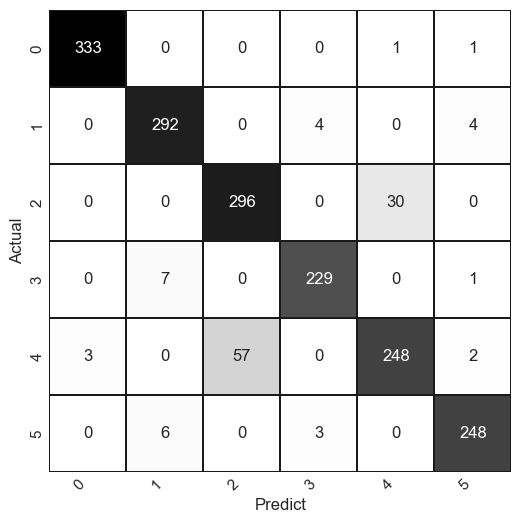

In [155]:
print(f"정확도 : {accuracy_score(lgb_y_test, bagging_predict):.4f}")

cm = pd.crosstab(lgb_y_test["Activity"].values , bagging_predict)

plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, cmap = "binary", cbar = False, square = True, fmt = "d", lw = 0.2, linecolor = "k" )
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.xticks(rotation = 45, ha = "right")

ax = plt.gca()


for label in ["bottom","top","left","right"]:
    ax.spines[label].set_color("k")
    ax.spines[label].set_visible(True)

In [136]:
print(classification_report(lgb_y_test, bagging_predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       335
           1       0.96      0.97      0.97       300
           2       0.84      0.91      0.87       326
           3       0.97      0.97      0.97       237
           4       0.89      0.80      0.84       310
           5       0.97      0.96      0.97       257

    accuracy                           0.93      1765
   macro avg       0.94      0.93      0.93      1765
weighted avg       0.93      0.93      0.93      1765

